In [1]:
from dotenv import load_dotenv
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
import os
from pydantic import BaseModel, Field
from typing import Literal, TypedDict
from langchain.agents import create_agent

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver
from langchain.tools import tool
from langsmith import Client
from setuptools import Command

import json

In [2]:
load_dotenv("/home/david/Git/JobScraper/backend/.env")

True

In [3]:
client = Client()
extraction_model = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0)
writing_model = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0.85)
editing_model = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0.4)

In [4]:
class State(TypedDict):
    job_description: str
    important_information: str
    resume: str
    required_technical_skills: str
    required_soft_skills: str
    resume_technical_skills: str
    resume_soft_skills: str
    technical_skills_paragraph: str
    soft_skills_paragraph: str
    opening_paragraph: str
    closing_paragraph: str
    full_cover_letter: str

In [5]:
def input_node(state: State) -> State:
    """Do input parsing, find the required technical and soft skills from the job description"""

    prompt = client.pull_prompt("job_description_input")
    prompt = prompt.invoke({"context": state["job_description"]})
    response = extraction_model.invoke(prompt).content

    json_output = json.loads(response)
    state["important_information"] = json_output["important_information"]
    state["required_technical_skills"] = json_output["required_technical_skills"]
    state["required_soft_skills"] = json_output["required_soft_skills"]
    
    return state


def technical_skills_extractor_node(state: State) -> State:
    """Extract technical skills from job description"""
    
    prompt = client.pull_prompt("resume_technical_skills_extractor")
    prompt = prompt.invoke({"technical_skills": state["required_technical_skills"], "resume": state["resume"]})
    response = extraction_model.invoke(prompt).content

    json_output = json.loads(response)
    state["resume_technical_skills"] = json_output["resume_technical_skills"]

    return state


def technical_skills_summariser_node(state: State) -> State:
    """Summarise technical skills from job description"""
    
    prompt = client.pull_prompt("resume_technical_skills_summariser")
    prompt = prompt.invoke({"important_information": state["important_information"], "technical_skills": state["resume_technical_skills"]})
    response = writing_model.invoke(prompt).content

    json_output = json.loads(response)
    state["technical_skills_paragraph"] = json_output["technical_skills_paragraph"]

    return state


def soft_skills_extractor_node(state: State) -> State:
    """Extract soft skills from job description"""
    
    prompt = client.pull_prompt("resume_soft_skills_extractor")
    prompt = prompt.invoke({"soft_skills": state["required_soft_skills"], "resume": state["resume"]})
    response = extraction_model.invoke(prompt).content

    json_output = json.loads(response)
    state["resume_soft_skills"] = json_output["resume_soft_skills"]

    return state


def soft_skills_summariser_node(state: State) -> State:
    """Summarise soft skills from job description"""
    
    prompt = client.pull_prompt("resume_soft_skills_summariser")
    prompt = prompt.invoke({"soft_skills": state["resume_soft_skills"], "important_information": state["important_information"]})
    response = writing_model.invoke(prompt).content

    json_output = json.loads(response)
    state["soft_skills_paragraph"] = json_output["soft_skills_paragraph"]

    return state


def opening_paragraph_node(state: State) -> State:
    """Generate opening paragraph for cover letter"""
    
    prompt = client.pull_prompt("resume_opening_paragraph_generator")
    prompt = prompt.invoke({"important_information": state["important_information"], "technical_skills_paragraph": state["technical_skills_paragraph"], "soft_skills_paragraph": state["soft_skills_paragraph"]})
    response = writing_model.invoke(prompt).content

    state["opening_paragraph"] = response

    return state


def closing_paragraph_node(state: State) -> State:
    """Generate closing paragraph for cover letter"""

    prompt = client.pull_prompt("resume_closing_paragraph_generator")
    prompt = prompt.invoke({"important_information": state["important_information"], "technical_skills_paragraph": state["technical_skills_paragraph"], "soft_skills_paragraph": state["soft_skills_paragraph"]})
    response = writing_model.invoke(prompt).content

    state["closing_paragraph"] = response

    return state
    

def output_node(state: State) -> State:
    """Generate full cover letter"""

    paragraphs = state["opening_paragraph"] + "\n\n" + state["technical_skills_paragraph"] + "\n\n" + state["soft_skills_paragraph"] + "\n\n" + state["closing_paragraph"]

    prompt = client.pull_prompt("resume_full_cover_letter_generator")
    prompt = prompt.invoke({"paragraphs": paragraphs, "important_information": state["important_information"]})
    response = editing_model.invoke(prompt).content

    state["full_cover_letter"] = response

    return state

In [6]:
# Build workflow
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("input_node", input_node)
builder.add_node("technical_skills_extractor_node", technical_skills_extractor_node)
builder.add_node("technical_skills_summariser_node", technical_skills_summariser_node)
builder.add_node("soft_skills_extractor_node", soft_skills_extractor_node)
builder.add_node("soft_skills_summariser_node", soft_skills_summariser_node)
builder.add_node("opening_paragraph_node", opening_paragraph_node)
builder.add_node("closing_paragraph_node", closing_paragraph_node)
builder.add_node("output_node", output_node)


builder.add_edge(START, "input_node")

builder.add_edge("input_node", "technical_skills_extractor_node")
builder.add_edge("technical_skills_extractor_node", "technical_skills_summariser_node")
builder.add_edge("technical_skills_summariser_node", "opening_paragraph_node")

builder.add_edge("input_node", "soft_skills_extractor_node")
builder.add_edge("soft_skills_extractor_node", "soft_skills_summariser_node")
builder.add_edge("soft_skills_summariser_node", "opening_paragraph_node")

builder.add_edge("opening_paragraph_node", "closing_paragraph_node")
builder.add_edge("closing_paragraph_node", "output_node")
builder.add_edge("output_node", END)


graph = builder.compile()

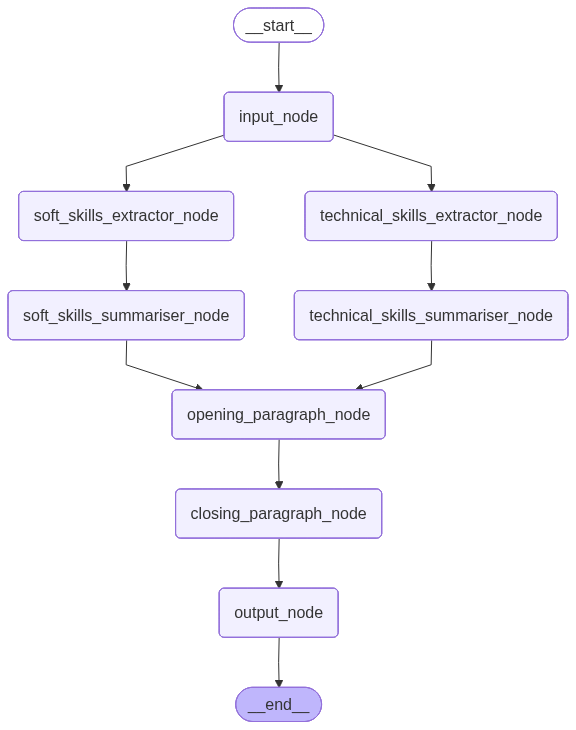

In [7]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())